In [8]:
#load libraries
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset, Dataset
from torchvision.datasets import ImageFolder
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import copy
import seaborn as sns

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#load dataset
data = np.load('/content/pneumoniamnist.npz')
print(data.files)

['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


In [11]:
#train_test_split
X_train = data['train_images']
y_train = data['train_labels']
X_val = data['val_images']
y_val = data['val_labels']
X_test = data['test_images']
y_test = data['test_labels']

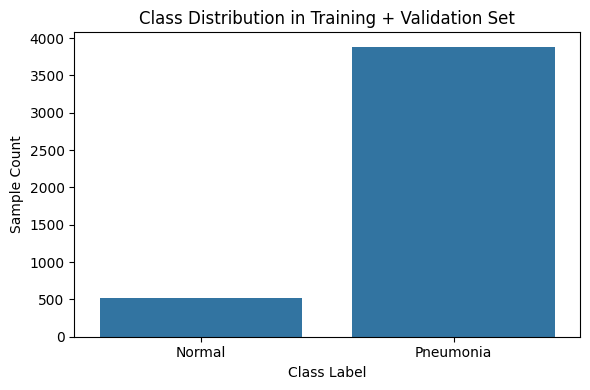

In [12]:
# Visualize Class Distribution
train_labels_flat = np.concatenate([y_train, y_val]).flatten()
unique, counts = np.unique(train_labels_flat, return_counts=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=unique, y=counts)
plt.xlabel('Class Label')
plt.ylabel('Sample Count')
plt.title('Class Distribution in Training + Validation Set')
plt.xticks(ticks=[0,1], labels=['Normal','Pneumonia'])
plt.tight_layout()
plt.show()

In [13]:
class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # shape: (N, 28, 28)
        self.labels = labels  # shape: (N, 1)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx][0])
        img = np.uint8(img)  # Convert to uint8 for PIL
        img = Image.fromarray(img, mode='L')  # Convert to PIL grayscale

        if self.transform:
            img = self.transform(img)

        return img, label

In [14]:
# Preprocess: Resize to 299x299 and convert grayscale to 3 channels
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [15]:
# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    return acc, f1, auc

In [16]:
# Prepare Datasets
X_all = np.concatenate([X_train, X_val], axis=0)
y_all = np.concatenate([y_train, y_val], axis=0)
full_dataset = PneumoniaDataset(X_all, y_all, transform=transform_train)
test_dataset = PneumoniaDataset(X_test, y_test, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
all_test_metrics = []

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_all)):
    print(f"\n--- Fold {fold+1}/5 ---")

    # Split into train and val subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(PneumoniaDataset(X_all, y_all, transform=transform_test), val_idx)

    # Class balancing for training fold
    labels_fold = y_all[train_idx].flatten()
    class_sample_count = np.array([len(np.where(labels_fold == t)[0]) for t in np.unique(labels_fold)])
    weights = 1. / class_sample_count
    samples_weight = np.array([weights[int(t)] for t in labels_fold])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Model
    model = models.inception_v3(pretrained=True, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Early Stopping Based on AUROC
    best_val_auc = 0
    trigger_times = 0
    patience = 5

    for epoch in range(20):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc, val_f1, val_auc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Val Acc={val_acc:.4f}, F1={val_f1:.4f}, AUROC={val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_wts = copy.deepcopy(model.state_dict())
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

model.load_state_dict(best_model_wts)
test_acc, test_f1, test_auc = evaluate(model, test_loader)
print(f"Fold {fold+1} Test: Accuracy={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_auc:.4f}")
all_test_metrics.append((test_acc, test_f1, test_auc))


--- Fold 1/5 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=20.3094, Val Acc=0.8435, F1=0.9036, AUROC=0.9121


In [ ]:
# Average Test Performance
avg_acc = np.mean([m[0] for m in all_test_metrics])
avg_f1 = np.mean([m[1] for m in all_test_metrics])
avg_auc = np.mean([m[2] for m in all_test_metrics])

print(f"\n Average Test Performance across 5 folds:")
print(f"Accuracy: {avg_acc:.4f}, F1-Score: {avg_f1:.4f}, AUROC: {avg_auc:.4f}")

# Evaluate on test set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
test_auc = roc_auc_score(all_labels, all_preds)
print(f" Fold {fold+1} Test: Accuracy={test_acc:.4f}, F1={test_f1:.4f}, AUROC={test_auc:.4f}")
all_test_metrics.append((test_acc, test_f1, test_auc))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - Fold {fold+1}')
plt.tight_layout()
plt.show()